# Example ANN generation and training

From melon doc (https://git.rwth-aachen.de/avt-svt/public/MeLOn/-/blob/master/feedforward%20neural%20network/training/keras/example_training_of_ANN.py) and the ANN paper (https://link.springer.com/content/pdf/10.1007/s10957-018-1396-0.pdf).

## Problem statement:
min $f(x)$

where $f$ is a feed forward neural network. 

The peaks function will be used as a dummy problem and will be approximated by $f$. The peaks function is defined as:

$$ g_{peaks}(x_1, x_2) = 3\cdot(1-x_1)^2 \cdot \exp[-x_1^2-(x_2+1)^2] -10\cdot (x_1/5-x_1^3-x_2^5)\cdot\exp(-x_1^2-x_2^2)- \exp[-(x_1+1)^2-x_2^2]/3$$

$$g_{peaks} : \mathbb{R}^2 \to \mathbb{R}$$

The function dominion is defined as $D = \{x_1, x_2 \in \mathbb{R}: -3 \leq x_1,x_2 \leq 3 \}$

The initial dataset will be generated by Latin hypercube sampling.

In [1]:
import utils
import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyDOE import lhs
import maingopy

Implement peaks function as defined above

In [2]:
def peaks(X):
    term1 = 3*np.multiply((1-X[:,0])**2, np.exp(-(X[:,0])**2-(X[:,1]+1)**2))
    term2 = np.multiply(-10*(X[:,0]/5-X[:,0]**3-X[:,1]**5), np.exp(-X[:,0]**2-X[:,1]**2))
    term3 = -np.exp(-(X[:,0]+1)**2-X[:,1]**2)/3
    y = term1 + term2 + term3
    return np.expand_dims(y, axis=-1)

In [3]:
# test global minimum at f(0.228, -1.626)=-6.551
peaks(np.array([[0.228, -1.626], [0.5,0.5]]))

array([[-6.55112995],
       [ 0.37537558]])

## Training data generation

Generate 500 samples with latin hypercube sampling (package pyDOE), rescale to [-3, 3] and evaluate.

In [4]:
lhd = lhs(2, samples=600)
Xpeaks = lhd*6-3
ypeaks = peaks(Xpeaks)

## Set parameters

In [5]:
problem_name = 'peaks'
# dimensionality of the data
input_dim = 2
output_dim = 1
# scale Input to [-1,1] range
scaleInput = True
# normalize Output to z-score
normalizeOutput = True

define scale and normalize (from melon keras utils)

In [6]:
def scale(X, scaleInput):
    # scale Input values to range [-1,1] in each dimension
    if (scaleInput):
        nom = (X -  X.min(axis=0))*2
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return -1 + nom/denom
    else:
        return X

def normalize(y, normalizeOutput):
    # normalize output to z-score
    if(normalizeOutput):
        y_norm = (y - np.mean(y, axis=0))/np.std(y, axis=0);
        return y_norm
    else:
        return y

In [7]:
Xnorm = scale(Xpeaks, scaleInput)
ynorm = normalize(ypeaks, normalizeOutput)

In [8]:
# split into test, validation and test sets (70-15-15% split)
Xtrain, Xval, ytrain, yval = train_test_split(Xnorm, ynorm, test_size=0.15)
n_train = Xtrain.shape[0]

## Set output parameters

Two hidden layers of 10, 8 (different from source paper)-> (2x10+1) + (10x8+1) + (8x1)+1 = 127 parameters to optimize.

ReLU activation function for the all activation functions exctept the output layer, which is linear. 

Learning by first-order stochastic gradient descent (ADAM, https://arxiv.org/abs/1412.6980) for 100 epochs with a 0.001 leraning rate (default).

In [9]:
# output filename
output_folder = "./data/Output/"
filename_out = output_folder + problem_name
# training parameters
network_layout = [10, 8]
activation_function = 'relu'
activation_function_out = 'linear'
learning_rate = 0.001
kernel_regularizer = tf.keras.regularizers.l2(l=0.0001)  # L2 regularization penalty
# 'he_normal' for relu activation, 'glorot_uniform' for everything else
kernel_initializer = 'he_normal'
# It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
optimizer = 'adam'
epochs = 1000
#batch_size = 128
random_state = 1

## Build model

With the inputs defined above:

keras.sequential: a plain stack of layers where each layer has exactly one input tensor and one output tensor.


In [10]:
# Sequential class: Linear stack of layers.
model = tf.keras.Sequential()
# Create and add first layer
model.add(tf.keras.layers.Dense(network_layout[0],
                                name="input",
                                kernel_initializer=kernel_initializer,
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function,
                                input_dim=input_dim))
# Create and add all remaining layers (in this case, 9x9 layout)
for neuron in network_layout[1:]:
    model.add(tf.keras.layers.Dense(neuron,
                                    kernel_initializer=kernel_initializer,
                                    kernel_regularizer=kernel_regularizer,
                                    activation=activation_function))
# Output layer w linear function
model.add(tf.keras.layers.Dense(output_dim, name="output",
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=kernel_regularizer,
                                activation=activation_function_out))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
# Generate a table summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                30        
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


## Train ANN model on dataset

First-order gradient-based optimization of stochastic objective functions (https://arxiv.org/abs/1412.6980)

In [11]:
############################  TRAINING ############################ 

training_time = time.time()

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=epochs, verbose=1)

# history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
#                     epochs=epochs, batch_size=batch_size, verbose=1)
training_time = training_time - time.time()

Epoch 1/1000
16/16 [==============================] - 0s 11ms/step - loss: 2.3999 - mse: 2.3957 - mae: 1.1687 - val_loss: 2.0756 - val_mse: 2.0713 - val_mae: 1.1347
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 1.7892 - mse: 1.7850 - mae: 1.0087 - val_loss: 1.6285 - val_mse: 1.6243 - val_mae: 0.9955
Epoch 3/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.4122 - mse: 1.4080 - mae: 0.9037 - val_loss: 1.3513 - val_mse: 1.3471 - val_mae: 0.8975
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 1.1948 - mse: 1.1906 - mae: 0.8359 - val_loss: 1.1882 - val_mse: 1.1840 - val_mae: 0.8271
Epoch 5/1000
16/16 [==============================] - 0s 1ms/step - loss: 1.0517 - mse: 1.0475 - mae: 0.7882 - val_loss: 1.1015 - val_mse: 1.0973 - val_mae: 0.7816
Epoch 6/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.9740 - mse: 0.9699 - mae: 0.7514 - val_loss: 1.0468 - val_mse: 1.0426 - val_mae: 0.7455
Epoch 7/1000
16

Epoch 51/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5905 - mse: 0.5860 - mae: 0.5352 - val_loss: 0.6893 - val_mse: 0.6848 - val_mae: 0.5816
Epoch 52/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5860 - mse: 0.5816 - mae: 0.5340 - val_loss: 0.6846 - val_mse: 0.6801 - val_mae: 0.5839
Epoch 53/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5833 - mse: 0.5787 - mae: 0.5327 - val_loss: 0.6814 - val_mse: 0.6769 - val_mae: 0.5826
Epoch 54/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5803 - mse: 0.5757 - mae: 0.5338 - val_loss: 0.6792 - val_mse: 0.6747 - val_mae: 0.5860
Epoch 55/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5760 - mse: 0.5715 - mae: 0.5328 - val_loss: 0.6733 - val_mse: 0.6687 - val_mae: 0.5833
Epoch 56/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.5754 - mse: 0.5709 - mae: 0.5289 - val_loss: 0.6724 - val_mse: 0.6678 - val_mae: 0.5727
Epoch 57/1

Epoch 101/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4831 - mse: 0.4781 - mae: 0.4975 - val_loss: 0.5624 - val_mse: 0.5574 - val_mae: 0.5561
Epoch 102/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4816 - mse: 0.4766 - mae: 0.4968 - val_loss: 0.5601 - val_mse: 0.5551 - val_mae: 0.5562
Epoch 103/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4802 - mse: 0.4752 - mae: 0.4977 - val_loss: 0.5572 - val_mse: 0.5522 - val_mae: 0.5568
Epoch 104/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4792 - mse: 0.4741 - mae: 0.4958 - val_loss: 0.5561 - val_mse: 0.5510 - val_mae: 0.5533
Epoch 105/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4769 - mse: 0.4718 - mae: 0.4941 - val_loss: 0.5556 - val_mse: 0.5505 - val_mae: 0.5519
Epoch 106/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4770 - mse: 0.4719 - mae: 0.4940 - val_loss: 0.5540 - val_mse: 0.5490 - val_mae: 0.5534
Epoc

16/16 [==============================] - 0s 2ms/step - loss: 0.4147 - mse: 0.4092 - mae: 0.4611 - val_loss: 0.4888 - val_mse: 0.4832 - val_mae: 0.5280
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4125 - mse: 0.4070 - mae: 0.4590 - val_loss: 0.4866 - val_mse: 0.4810 - val_mae: 0.5259
Epoch 152/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4120 - mse: 0.4065 - mae: 0.4599 - val_loss: 0.4851 - val_mse: 0.4795 - val_mae: 0.5255
Epoch 153/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.4095 - mse: 0.4039 - mae: 0.4582 - val_loss: 0.4827 - val_mse: 0.4772 - val_mae: 0.5239
Epoch 154/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4090 - mse: 0.4034 - mae: 0.4566 - val_loss: 0.4822 - val_mse: 0.4766 - val_mae: 0.5245
Epoch 155/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.4066 - mse: 0.4010 - mae: 0.4581 - val_loss: 0.4810 - val_mse: 0.4754 - val_mae: 0.5253
Epoch 156/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.3449 - mse: 0.3387 - mae: 0.4195 - val_loss: 0.4163 - val_mse: 0.4102 - val_mae: 0.4866
Epoch 200/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.3429 - mse: 0.3367 - mae: 0.4177 - val_loss: 0.4122 - val_mse: 0.4060 - val_mae: 0.4835
Epoch 201/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.3413 - mse: 0.3351 - mae: 0.4151 - val_loss: 0.4140 - val_mse: 0.4078 - val_mae: 0.4789
Epoch 202/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.3408 - mse: 0.3346 - mae: 0.4155 - val_loss: 0.4055 - val_mse: 0.3993 - val_mae: 0.4813
Epoch 203/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.3388 - mse: 0.3326 - mae: 0.4145 - val_loss: 0.4060 - val_mse: 0.3997 - val_mae: 0.4774
Epoch 204/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.3372 - mse: 0.3310 - mae: 0.4133 - val_loss: 0.4061 - val_mse: 0.3998 - val_mae: 0.4746
Epoch 205/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.2640 - mse: 0.2571 - mae: 0.3587 - val_loss: 0.3418 - val_mse: 0.3349 - val_mae: 0.4358
Epoch 249/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2630 - mse: 0.2561 - mae: 0.3572 - val_loss: 0.3403 - val_mse: 0.3334 - val_mae: 0.4353
Epoch 250/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2620 - mse: 0.2550 - mae: 0.3556 - val_loss: 0.3384 - val_mse: 0.3315 - val_mae: 0.4338
Epoch 251/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2628 - mse: 0.2559 - mae: 0.3582 - val_loss: 0.3385 - val_mse: 0.3316 - val_mae: 0.4395
Epoch 252/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2602 - mse: 0.2532 - mae: 0.3557 - val_loss: 0.3362 - val_mse: 0.3293 - val_mae: 0.4311
Epoch 253/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2588 - mse: 0.2519 - mae: 0.3529 - val_loss: 0.3347 - val_mse: 0.3277 - val_mae: 0.4317
Epoch 254/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.2230 - mse: 0.2155 - mae: 0.3313 - val_loss: 0.2888 - val_mse: 0.2812 - val_mae: 0.4100
Epoch 298/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.2241 - mse: 0.2165 - mae: 0.3287 - val_loss: 0.2842 - val_mse: 0.2766 - val_mae: 0.3975
Epoch 299/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2205 - mse: 0.2129 - mae: 0.3262 - val_loss: 0.2844 - val_mse: 0.2768 - val_mae: 0.4041
Epoch 300/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2201 - mse: 0.2125 - mae: 0.3239 - val_loss: 0.2840 - val_mse: 0.2764 - val_mae: 0.4024
Epoch 301/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2193 - mse: 0.2117 - mae: 0.3259 - val_loss: 0.2808 - val_mse: 0.2732 - val_mae: 0.4016
Epoch 302/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.2190 - mse: 0.2114 - mae: 0.3252 - val_loss: 0.2801 - val_mse: 0.2725 - val_mae: 0.3992
Epoch 303/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.1901 - mse: 0.1820 - mae: 0.3024 - val_loss: 0.2348 - val_mse: 0.2268 - val_mae: 0.3653
Epoch 347/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1877 - mse: 0.1797 - mae: 0.3010 - val_loss: 0.2353 - val_mse: 0.2272 - val_mae: 0.3688
Epoch 348/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1875 - mse: 0.1794 - mae: 0.3011 - val_loss: 0.2337 - val_mse: 0.2256 - val_mae: 0.3636
Epoch 349/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1881 - mse: 0.1800 - mae: 0.3027 - val_loss: 0.2374 - val_mse: 0.2293 - val_mae: 0.3714
Epoch 350/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1861 - mse: 0.1780 - mae: 0.2990 - val_loss: 0.2338 - val_mse: 0.2257 - val_mae: 0.3663
Epoch 351/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1860 - mse: 0.1779 - mae: 0.2993 - val_loss: 0.2320 - val_mse: 0.2239 - val_mae: 0.3648
Epoch 352/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.1606 - mse: 0.1521 - mae: 0.2806 - val_loss: 0.1960 - val_mse: 0.1875 - val_mae: 0.3391
Epoch 396/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1600 - mse: 0.1514 - mae: 0.2790 - val_loss: 0.1948 - val_mse: 0.1862 - val_mae: 0.3345
Epoch 397/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1596 - mse: 0.1510 - mae: 0.2779 - val_loss: 0.1980 - val_mse: 0.1895 - val_mae: 0.3422
Epoch 398/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1592 - mse: 0.1507 - mae: 0.2786 - val_loss: 0.1928 - val_mse: 0.1843 - val_mae: 0.3328
Epoch 399/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1592 - mse: 0.1506 - mae: 0.2799 - val_loss: 0.1948 - val_mse: 0.1862 - val_mae: 0.3389
Epoch 400/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.1587 - mse: 0.1501 - mae: 0.2781 - val_loss: 0.1937 - val_mse: 0.1851 - val_mae: 0.3381
Epoch 401/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.1338 - mse: 0.1247 - mae: 0.2558 - val_loss: 0.1635 - val_mse: 0.1545 - val_mae: 0.3083
Epoch 445/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1347 - mse: 0.1257 - mae: 0.2546 - val_loss: 0.1605 - val_mse: 0.1515 - val_mae: 0.3054
Epoch 446/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1333 - mse: 0.1242 - mae: 0.2541 - val_loss: 0.1619 - val_mse: 0.1528 - val_mae: 0.3076
Epoch 447/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1330 - mse: 0.1240 - mae: 0.2539 - val_loss: 0.1599 - val_mse: 0.1509 - val_mae: 0.3051
Epoch 448/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1329 - mse: 0.1238 - mae: 0.2534 - val_loss: 0.1600 - val_mse: 0.1509 - val_mae: 0.3053
Epoch 449/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1332 - mse: 0.1241 - mae: 0.2545 - val_loss: 0.1608 - val_mse: 0.1517 - val_mae: 0.3043
Epoch 450/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.1205 - mse: 0.1111 - mae: 0.2421 - val_loss: 0.1463 - val_mse: 0.1368 - val_mae: 0.2903
Epoch 494/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1192 - mse: 0.1098 - mae: 0.2398 - val_loss: 0.1460 - val_mse: 0.1366 - val_mae: 0.2909
Epoch 495/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1207 - mse: 0.1113 - mae: 0.2400 - val_loss: 0.1436 - val_mse: 0.1342 - val_mae: 0.2854
Epoch 496/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1192 - mse: 0.1098 - mae: 0.2401 - val_loss: 0.1467 - val_mse: 0.1373 - val_mae: 0.2937
Epoch 497/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1204 - mse: 0.1110 - mae: 0.2425 - val_loss: 0.1467 - val_mse: 0.1372 - val_mae: 0.2938
Epoch 498/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1188 - mse: 0.1093 - mae: 0.2394 - val_loss: 0.1468 - val_mse: 0.1373 - val_mae: 0.2971
Epoch 499/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.1106 - mse: 0.1009 - mae: 0.2347 - val_loss: 0.1305 - val_mse: 0.1207 - val_mae: 0.2722
Epoch 543/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1102 - mse: 0.1004 - mae: 0.2328 - val_loss: 0.1295 - val_mse: 0.1197 - val_mae: 0.2714
Epoch 544/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1079 - mse: 0.0982 - mae: 0.2297 - val_loss: 0.1313 - val_mse: 0.1215 - val_mae: 0.2744
Epoch 545/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1084 - mse: 0.0987 - mae: 0.2304 - val_loss: 0.1292 - val_mse: 0.1194 - val_mae: 0.2696
Epoch 546/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1085 - mse: 0.0988 - mae: 0.2303 - val_loss: 0.1291 - val_mse: 0.1193 - val_mae: 0.2718
Epoch 547/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.1092 - mse: 0.0994 - mae: 0.2328 - val_loss: 0.1326 - val_mse: 0.1228 - val_mae: 0.2783
Epoch 548/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0996 - mse: 0.0895 - mae: 0.2241 - val_loss: 0.1193 - val_mse: 0.1092 - val_mae: 0.2567
Epoch 592/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0986 - mse: 0.0885 - mae: 0.2209 - val_loss: 0.1206 - val_mse: 0.1105 - val_mae: 0.2583
Epoch 593/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0992 - mse: 0.0891 - mae: 0.2224 - val_loss: 0.1219 - val_mse: 0.1118 - val_mae: 0.2617
Epoch 594/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0990 - mse: 0.0889 - mae: 0.2209 - val_loss: 0.1195 - val_mse: 0.1093 - val_mae: 0.2549
Epoch 595/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0993 - mse: 0.0892 - mae: 0.2223 - val_loss: 0.1208 - val_mse: 0.1107 - val_mae: 0.2588
Epoch 596/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0991 - mse: 0.0889 - mae: 0.2234 - val_loss: 0.1198 - val_mse: 0.1097 - val_mae: 0.2562
Epoch 597/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0902 - mse: 0.0798 - mae: 0.2120 - val_loss: 0.1137 - val_mse: 0.1033 - val_mae: 0.2491
Epoch 641/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0907 - mse: 0.0803 - mae: 0.2121 - val_loss: 0.1162 - val_mse: 0.1059 - val_mae: 0.2528
Epoch 642/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0920 - mse: 0.0817 - mae: 0.2145 - val_loss: 0.1117 - val_mse: 0.1013 - val_mae: 0.2421
Epoch 643/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0898 - mse: 0.0794 - mae: 0.2115 - val_loss: 0.1131 - val_mse: 0.1027 - val_mae: 0.2489
Epoch 644/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0915 - mse: 0.0811 - mae: 0.2162 - val_loss: 0.1133 - val_mse: 0.1029 - val_mae: 0.2520
Epoch 645/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0911 - mse: 0.0808 - mae: 0.2155 - val_loss: 0.1123 - val_mse: 0.1019 - val_mae: 0.2442
Epoch 646/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0837 - mse: 0.0732 - mae: 0.2031 - val_loss: 0.1116 - val_mse: 0.1010 - val_mae: 0.2504
Epoch 690/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0853 - mse: 0.0747 - mae: 0.2071 - val_loss: 0.1138 - val_mse: 0.1032 - val_mae: 0.2528
Epoch 691/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0841 - mse: 0.0735 - mae: 0.2036 - val_loss: 0.1087 - val_mse: 0.0981 - val_mae: 0.2431
Epoch 692/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0839 - mse: 0.0733 - mae: 0.2048 - val_loss: 0.1074 - val_mse: 0.0969 - val_mae: 0.2379
Epoch 693/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0833 - mse: 0.0727 - mae: 0.2032 - val_loss: 0.1095 - val_mse: 0.0989 - val_mae: 0.2439
Epoch 694/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0841 - mse: 0.0735 - mae: 0.2049 - val_loss: 0.1089 - val_mse: 0.0983 - val_mae: 0.2418
Epoch 695/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0796 - mse: 0.0688 - mae: 0.2001 - val_loss: 0.1041 - val_mse: 0.0933 - val_mae: 0.2339
Epoch 739/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0797 - mse: 0.0690 - mae: 0.1993 - val_loss: 0.1093 - val_mse: 0.0985 - val_mae: 0.2479
Epoch 740/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0820 - mse: 0.0712 - mae: 0.2050 - val_loss: 0.1058 - val_mse: 0.0950 - val_mae: 0.2354
Epoch 741/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0804 - mse: 0.0696 - mae: 0.2016 - val_loss: 0.1026 - val_mse: 0.0918 - val_mae: 0.2321
Epoch 742/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0785 - mse: 0.0677 - mae: 0.1983 - val_loss: 0.1030 - val_mse: 0.0922 - val_mae: 0.2336
Epoch 743/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0786 - mse: 0.0678 - mae: 0.1997 - val_loss: 0.1037 - val_mse: 0.0930 - val_mae: 0.2354
Epoch 744/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0755 - mse: 0.0646 - mae: 0.1954 - val_loss: 0.1005 - val_mse: 0.0896 - val_mae: 0.2316
Epoch 788/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0751 - mse: 0.0641 - mae: 0.1949 - val_loss: 0.0986 - val_mse: 0.0877 - val_mae: 0.2261
Epoch 789/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0751 - mse: 0.0642 - mae: 0.1930 - val_loss: 0.0995 - val_mse: 0.0886 - val_mae: 0.2280
Epoch 790/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0752 - mse: 0.0643 - mae: 0.1923 - val_loss: 0.0990 - val_mse: 0.0881 - val_mae: 0.2255
Epoch 791/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0751 - mse: 0.0642 - mae: 0.1946 - val_loss: 0.1064 - val_mse: 0.0955 - val_mae: 0.2443
Epoch 792/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0775 - mse: 0.0666 - mae: 0.1959 - val_loss: 0.1009 - val_mse: 0.0900 - val_mae: 0.2328
Epoch 793/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0751 - mse: 0.0640 - mae: 0.1954 - val_loss: 0.1045 - val_mse: 0.0934 - val_mae: 0.2436
Epoch 837/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0716 - mse: 0.0605 - mae: 0.1911 - val_loss: 0.0976 - val_mse: 0.0866 - val_mae: 0.2263
Epoch 838/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0719 - mse: 0.0608 - mae: 0.1904 - val_loss: 0.0961 - val_mse: 0.0851 - val_mae: 0.2236
Epoch 839/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0717 - mse: 0.0606 - mae: 0.1874 - val_loss: 0.1012 - val_mse: 0.0901 - val_mae: 0.2367
Epoch 840/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0732 - mse: 0.0622 - mae: 0.1915 - val_loss: 0.0990 - val_mse: 0.0879 - val_mae: 0.2286
Epoch 841/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0710 - mse: 0.0599 - mae: 0.1881 - val_loss: 0.0974 - val_mse: 0.0863 - val_mae: 0.2255
Epoch 842/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0690 - mse: 0.0579 - mae: 0.1842 - val_loss: 0.0965 - val_mse: 0.0854 - val_mae: 0.2248
Epoch 886/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0675 - mse: 0.0563 - mae: 0.1811 - val_loss: 0.0959 - val_mse: 0.0847 - val_mae: 0.2202
Epoch 887/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0693 - mse: 0.0581 - mae: 0.1832 - val_loss: 0.0959 - val_mse: 0.0847 - val_mae: 0.2215
Epoch 888/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0696 - mse: 0.0585 - mae: 0.1851 - val_loss: 0.0967 - val_mse: 0.0855 - val_mae: 0.2273
Epoch 889/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0692 - mse: 0.0580 - mae: 0.1871 - val_loss: 0.1014 - val_mse: 0.0903 - val_mae: 0.2360
Epoch 890/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0703 - mse: 0.0591 - mae: 0.1917 - val_loss: 0.0972 - val_mse: 0.0861 - val_mae: 0.2279
Epoch 891/1000
16/1

16/16 [==============================] - 0s 2ms/step - loss: 0.0671 - mse: 0.0559 - mae: 0.1843 - val_loss: 0.0943 - val_mse: 0.0831 - val_mae: 0.2243
Epoch 935/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0667 - mse: 0.0554 - mae: 0.1841 - val_loss: 0.0966 - val_mse: 0.0854 - val_mae: 0.2309
Epoch 936/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0663 - mse: 0.0551 - mae: 0.1800 - val_loss: 0.0968 - val_mse: 0.0856 - val_mae: 0.2256
Epoch 937/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0650 - mse: 0.0538 - mae: 0.1778 - val_loss: 0.0961 - val_mse: 0.0849 - val_mae: 0.2284
Epoch 938/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0659 - mse: 0.0547 - mae: 0.1797 - val_loss: 0.0925 - val_mse: 0.0813 - val_mae: 0.2187
Epoch 939/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0657 - mse: 0.0545 - mae: 0.1790 - val_loss: 0.0942 - val_mse: 0.0830 - val_mae: 0.2199
Epoch 940/1000
16/1

16/16 [==============================] - 0s 1ms/step - loss: 0.0631 - mse: 0.0518 - mae: 0.1737 - val_loss: 0.0929 - val_mse: 0.0816 - val_mae: 0.2222
Epoch 984/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0630 - mse: 0.0517 - mae: 0.1754 - val_loss: 0.0921 - val_mse: 0.0808 - val_mae: 0.2198
Epoch 985/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0652 - mse: 0.0539 - mae: 0.1811 - val_loss: 0.0917 - val_mse: 0.0804 - val_mae: 0.2181
Epoch 986/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0636 - mse: 0.0523 - mae: 0.1754 - val_loss: 0.0926 - val_mse: 0.0813 - val_mae: 0.2173
Epoch 987/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0632 - mse: 0.0519 - mae: 0.1729 - val_loss: 0.0910 - val_mse: 0.0796 - val_mae: 0.2156
Epoch 988/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0636 - mse: 0.0523 - mae: 0.1747 - val_loss: 0.0913 - val_mse: 0.0800 - val_mae: 0.2176
Epoch 989/1000
16/1

In [12]:
# Save entire model to a HDF5 file
model.save(filename_out + '_model.h5')
# Save model to XML
utils.save_model_to_xml(filename_out + '.xml', model, Xpeaks, ypeaks, scaleInput, normalizeOutput)
# plot predictions
y_pred = model.predict(Xnorm)

## Plot surrogate function

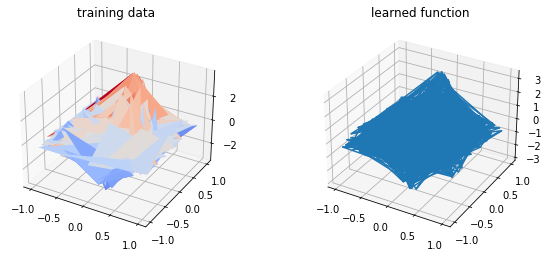

In [13]:
############################ PLOT PREDICTIONS ############################ 
n_train = Xnorm.shape[0]
n_rt = np.sqrt(n_train).astype(int)
X = np.zeros((n_rt, n_rt))
Y = np.zeros((n_rt, n_rt))
Z_true = np.zeros((n_rt, n_rt))
Z_pred = np.zeros((n_rt, n_rt))
for i in range(n_rt):
    for j in range(n_rt):
        X[i, j] = Xnorm[i * n_rt + j, 0]
        Y[i, j] = Xnorm[i * n_rt + j, 1]
        Z_true[i, j] = ynorm[i * n_rt + j]
        Z_pred[i, j] = y_pred[i * n_rt + j]

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
cmap = plt.get_cmap('coolwarm')
ax.plot_surface(X, Y, Z_true, cmap=cmap)
ax.set_title('training data')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(X, Y, Z_pred)
ax.set_title('learned function')
plt.show()


## Optimize surrogate model with maingopy

Melon computes the relaxations of the feed forward network ````maingopy.melonpy.FeedForwardNet()```` needed by the B&B solver by providing envelopes of the activation functions (currently supported: purelin, linear, tanh, tansig, relu, relu6). The procedure is the same with gaussian processes and support vector machines.

We load the trained model information from the generated XML file (see utils for details). which will be the optimization problem parameters. Then, we define the problem bounds of $D$ (see problem definition) in maingopy. Lastly, we define the evaluation function for maingopy.

Maingopy then takes the envelopes of the ANN and performs a global deterministic optimization (it is  B&B solver with a reduced space formulation for these envelopes, speeding up computation: https://www.avt.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaabclahw). 

In [14]:
# To define a model, we need to spcecialize the MAiNGOmodel class
class Model(maingopy.MAiNGOmodel):
    def __init__(self):
        maingopy.MAiNGOmodel.__init__(self)
        # Initialize feedforward neural network and load data from example csv file
        self.ffANN = maingopy.melonpy.FeedForwardNet()
        # folder where the model xml is stored
        self.path = "./data/Output/"
        # xml filename
        self.fileName= "peaks"
        # open them (define that it is an XML instead of a CSV)
        self.ffANN.load_model(self.path, self.fileName, maingopy.melonpy.XML)

    # We need to implement the get_variables functions for specifying the optimization varibles
    def get_variables(self):
        # define bounds of the original variables, so that it rescales the results fo the optimization
        # the optimization is done with the normalized version of these values
        variables = [ maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "x"),
                      maingopy.OptimizationVariable(maingopy.Bounds(-3,3), maingopy.VT_CONTINUOUS, "y") ]
        return variables

    # We need to implement the evaluate function that computes the values of the objective and constraints from the variables.
    # Note that the variables in the 'vars' argument of this function do correspond to the optimization variables defined in the get_variables function.
    # However, they are different objects for technical reasons. The only mapping we have between them is the position in the list.
    # The results of the evaluation (i.e., objective and constraint values) need to be return in an EvaluationContainer
    def evaluate(self, vars):
        x = vars[0]
        y = vars[1]
        
        # Inputs to the ANN are the variables x and y
        annInputs = [x, y]
        
        # Evaluate the network (in reduced-space)
        # This returns a list, because the output of the network may be multidimensional
        annOutputs = self.ffANN.calculate_prediction_reduced_space(annInputs)

        # Set the ANN output (only 1 in this case) as objective to be minimized
        result = maingopy.EvaluationContainer()
        result.objective = annOutputs[0]

        return result

In [15]:
# To work with the problem, we first create an instance of the model.
myModel = Model()
# We then create an instance of MAiNGO, the solver, and hand it the model.
myMAiNGO = maingopy.MAiNGO(myModel)

In [16]:
# We can have MAiNGO read a settings file:
#fileName = ""
#myMAiNGO.read_settings(fileName) # If fileName is empty, MAiNGO will attempt to open MAiNGOSettings.txt
myMAiNGO.set_log_file_name(".logs/my_log_file.log")
myMAiNGO.set_option("writeCsv", True)
myMAiNGO.set_iterations_csv_file_name(".logs/iterations.csv")
myMAiNGO.set_solution_and_statistics_csv_file_name(".logs/solution_and_statistics.csv")

You can see the input in form of a GAMS file in case you are interested in ````./logs/my_problem_file_MAiNGO.gms````.

In [17]:
myMAiNGO.write_model_to_file_in_other_language(writingLanguage=maingopy.LANG_GAMS, fileName="./logs/my_problem_file_MAiNGO.gms", solverName="SCIP", writeRelaxationOnly=False)

### Solution

In [18]:
# Finally, we call the solve routine to solve the problem.
maingoStatus = myMAiNGO.solve()
print(maingoStatus)

RETCODE.GLOBALLY_OPTIMAL


In [19]:
print("Global optimum: f([{}, {}]) = {}".format(myMAiNGO.get_solution_point()[0], myMAiNGO.get_solution_point()[1], myMAiNGO.get_objective_value()))

Global optimum: f([0.40209134304991623, -1.5822142781358306]) = -5.932259480080097


In [20]:
print("ANN value at true minimum = g(0.228, -1.626) = {}".format(myMAiNGO.evaluate_model_at_point(np.array([0.228, -1.626]))))

ANN value at true minimum = g(0.228, -1.626) = ([-5.670068718652875], True)
